# Data Preprocessing

In [0]:
from pyspark.sql.functions import expr
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
from pyspark.sql.functions import datediff,date_format,to_date,to_timestamp,year,month
from pyspark.sql import SparkSession
#using options
dfbank = spark.read.option("delimiter", ";").option("header", "true").option("inferSchema","true").csv("/FileStore/tables/bank_additional_full.csv")


###Feature Extraction

In [0]:
##Renaming columns and creating new variables pdaysnew:when customers are not contacted(999) then 0 else 1
#contactnew: when contact is cellular then 0 else 1
dfbank=dfbank.withColumnRenamed("emp.var.rate","employeevarrate").\
withColumnRenamed("cons.price.idx","consumerpriceindex").\
withColumnRenamed("cons.conf.idx","consumerconfidx").\
withColumnRenamed("nr.employed","nremployed").\
withColumn("output",expr("case when y='yes' then 1 else 0 end")).\
withColumn("pdaysnew",expr("case when pdays==999 then 0 else 1 end")).\
withColumn("contactnew",expr("case when contact='cellular' then 0 else 1 end"))
dfbank.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---------------+------------------+---------------+---------+----------+---+------+--------+----------+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|employeevarrate|consumerpriceindex|consumerconfidx|euribor3m|nremployed|  y|output|pdaysnew|contactnew|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---------------+------------------+---------------+---------+----------+---+------+--------+----------+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|            1.1|            93.994|          -36.4|    4.857|    5191.0| no|     0|       0|         1|
| 57|   services| marrie

#####1) Creating new column age_bucket using bucketizer

In [0]:
##Classify ages into teen adult midage and senior categories
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[ 0, 18, 35, 65, float('Inf') ],inputCol="age", outputCol="buckets")
df_buck = bucketizer.setHandleInvalid("keep").transform(dfbank)
df_buck.show()


+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---------------+------------------+---------------+---------+----------+---+------+--------+----------+-------+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|employeevarrate|consumerpriceindex|consumerconfidx|euribor3m|nremployed|  y|output|pdaysnew|contactnew|buckets|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---------------+------------------+---------------+---------+----------+---+------+--------+----------+-------+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|            1.1|            93.994|          -36.4|    4.857|    5191.0| no|     0|       0|         1| 

In [0]:
t = {0.0:"Teen", 1.0: "Adult", 2.0:"MidAge", 3.0: "Senior"}
udf_foo = udf(lambda x: t[x], StringType())
dfbank=df_buck.withColumn("age_bucket", udf_foo("buckets"))
dfbank.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---------------+------------------+---------------+---------+----------+---+------+--------+----------+-------+----------+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|employeevarrate|consumerpriceindex|consumerconfidx|euribor3m|nremployed|  y|output|pdaysnew|contactnew|buckets|age_bucket|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+---------------+------------------+---------------+---------+----------+---+------+--------+----------+-------+----------+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|            1.1|            93.994|          -36.4|    4.857|    5191.0

#####2) Creating scaled values for numerical inputs

In [0]:
##customer min max scaler function to scale input numerical values
def min_max_scaler(df, cols_to_scale):
  # Takes a dataframe and list of columns to minmax scale. Returns a dataframe.
  for col in cols_to_scale:
    # Define min and max values and collect them
    max_days = df.agg({col: 'max'}).collect()[0][0]
    min_days = df.agg({col: 'min'}).collect()[0][0]
    new_column_name = 'scaled_' + col
    # Create a new column based off the scaled data
    df = df.withColumn(new_column_name, 
                      (df[col] - min_days) / (max_days - min_days))
  return df

In [0]:
cols_to_scale = ['duration', 'consumerpriceindex', 'consumerconfidx','euribor3m','nremployed']

min_max_scaler(dfbank, cols_to_scale)[['duration','scaled_duration', 
                                   'consumerpriceindex', 'scaled_consumerpriceindex', 
                                   'euribor3m', 'scaled_euribor3m','nremployed','scaled_nremployed']]\
                                     .show(5)

+--------+--------------------+------------------+-------------------------+---------+------------------+----------+------------------+
|duration|     scaled_duration|consumerpriceindex|scaled_consumerpriceindex|euribor3m|  scaled_euribor3m|nremployed| scaled_nremployed|
+--------+--------------------+------------------+-------------------------+---------+------------------+----------+------------------+
|     261| 0.05307035380235868|            93.994|       0.6987529228371023|    4.857|0.9573792790750397|    5191.0|0.8597353497164447|
|     149| 0.03029686864579097|            93.994|       0.6987529228371023|    4.857|0.9573792790750397|    5191.0|0.8597353497164447|
|     226|0.045953639690931275|            93.994|       0.6987529228371023|    4.857|0.9573792790750397|    5191.0|0.8597353497164447|
|     151|0.030703538023586822|            93.994|       0.6987529228371023|    4.857|0.9573792790750397|    5191.0|0.8597353497164447|
|     307| 0.06242374949166328|            93.99

In [0]:
#create temporary values
dfbank.createOrReplaceTempView("bank")

In [0]:
dfbank.schema


Out[9]: StructType(List(StructField(age,IntegerType,true),StructField(job,StringType,true),StructField(marital,StringType,true),StructField(education,StringType,true),StructField(default,StringType,true),StructField(housing,StringType,true),StructField(loan,StringType,true),StructField(contact,StringType,true),StructField(month,StringType,true),StructField(day_of_week,StringType,true),StructField(duration,IntegerType,true),StructField(campaign,IntegerType,true),StructField(pdays,IntegerType,true),StructField(previous,IntegerType,true),StructField(poutcome,StringType,true),StructField(employeevarrate,DoubleType,true),StructField(consumerpriceindex,DoubleType,true),StructField(consumerconfidx,DoubleType,true),StructField(euribor3m,DoubleType,true),StructField(nremployed,DoubleType,true),StructField(y,StringType,true),StructField(output,IntegerType,false),StructField(pdaysnew,IntegerType,false),StructField(contactnew,IntegerType,false),StructField(buckets,DoubleType,true),StructField(age_

In [0]:
print((dfbank.count(), len(dfbank.columns)))

(41188, 26)


#Exploratory Data Analysis

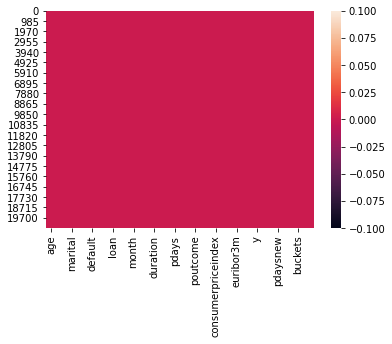

In [0]:
#Heatmap for missing values in dataset There are no missing values in the dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
#plot missing values in df using heatmap
sample_df = dfbank.sample(False, 0.5, 42)
pandas_df = sample_df.toPandas()

# Convert all values to T/F
tf_df = pandas_df.isnull()

# Plot it
sns.heatmap(data=tf_df)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

In [0]:
%sql

select y, cast(count(y)*100/sum(count(y)) over() as decimal(4,2)) as Percentage from bank group by y

y,Percentage
no,88.73
yes,11.27


In [0]:
#from the above plot, we can understand that the data is imbalanced with 88% of customers not subscribing to term deposit and 11% of subscribers subscribing to term deposit

In [0]:
%sql

select job,y,CAST(count(job)*100/sum(count(job)) over(partition by y) as decimal(4,2)) as percentage from bank  group by job,y

job,y,percentage
admin.,no,24.82
management,no,7.10
blue-collar,no,23.57
student,no,1.64
unknown,no,0.80
technician,no,16.45
unemployed,no,2.38
self-employed,no,3.48
housemaid,no,2.61
entrepreneur,no,3.64


In [0]:
#From the above plot, majority of customers agreing to term deposit are admins,technicians and blue collared jobs

In [0]:
%sql

select marital,y,CAST(count(marital)*100/sum(count(marital)) over(partition by y) as decimal(4,2)) as percentage from bank group by marital,y

marital,y,percentage
unknown,no,0.19
single,no,27.22
divorced,no,11.32
married,no,61.28
divorced,yes,10.26
single,yes,34.91
unknown,yes,0.26
married,yes,54.57


In [0]:
# From the above plot married people are highest subscribers of term deposit 

In [0]:
%sql
select housing,y,CAST(count(housing)*100/sum(count(housing)) over(partition by y) as decimal(4,2)) as percentage from bank group by housing,y

housing,y,percentage
no,no,45.41
unknown,no,2.42
yes,no,52.18
no,yes,43.66
unknown,yes,2.31
yes,yes,54.03


In [0]:
#From the above plot subscribers who agreed to term deposit had housing loans

In [0]:
%sql
select default,y,CAST(count(default)*100/sum(count(default)) over(partition by y) as decimal(4,2)) as percentage from bank  group by default,y

default,y,percentage
no,no,77.68
unknown,no,22.31
yes,no,0.01
no,yes,90.45
unknown,yes,9.55


In [0]:
#From the above plot customers who subscribed highest to term deposit did not have any default loans

In [0]:
%sql
select education,y,CAST(count(education)*100/sum(count(education)) over(partition by y) as decimal(4,2)) as percentage from bank  group by education,y

education,y,percentage
university.degree,no,28.72
unknown,no,4.05
basic.4y,no,10.26
professional.course,no,12.72
illiterate,no,0.04
basic.6y,no,5.76
high.school,no,23.21
basic.9y,no,15.25
professional.course,yes,12.82
basic.4y,yes,9.22


In [0]:
#From the above plot customers who highely subscribed to term deposit had university degrees

In [0]:
%sql
select loan,y,CAST(count(loan)*100/sum(count(loan)) over(partition by y) as decimal(4,2)) as percentage from bank  group by loan,y

loan,y,percentage
no,no,82.36
unknown,no,2.42
yes,no,15.23
no,yes,82.97
unknown,yes,2.31
yes,yes,14.72


In [0]:
#People who subscribed to term deposit majority of them did not have any loans

In [0]:
%sql

select poutcome,y,CAST(count(poutcome)*100/sum(count(poutcome)) over(partition by y) as decimal(4,2)) as percentage from bank  group by poutcome,y

poutcome,y,percentage
nonexistent,no,88.71
failure,no,9.98
success,no,1.31
nonexistent,yes,67.69
failure,yes,13.04
success,yes,19.27


In [0]:
#Among majority of subscribers to term deposit,previous outcome of campaigns were non existent

In [0]:
%sql

select age,y from bank

age,y
56,no
57,no
37,no
40,no
56,no
45,no
59,no
41,no
24,no
25,no


In [0]:
##Ages for majority of people ranges from 36 to 49 from the dataset

In [0]:
%sql
select duration,y from bank

duration,y
261,no
149,no
226,no
151,no
307,no
198,no
139,no
217,no
380,no
50,no


In [0]:
#duration is highly biased value in dataset, if duration is less the chances of customer agreeing for deposit is very less

In [0]:
%sql

select pdays,count(pdays) as totaltimescontacted from bank group by pdays order by totaltimescontacted desc

pdays,totaltimescontacted
999,39673
3,439
6,412
4,118
9,64
2,61
7,60
12,58
10,52
5,46


In [0]:
##if value for pdays is 999, then the customer was never contacted before, there are around 39k values for customers not contacted before.

In [0]:
%sql

select previous,y,CAST(count(previous)*100/sum(count(previous)) over(partition by y) as decimal(4,2)) as percentage from bank  group by previous,y

previous,y,percentage
1,no,9.83
2,no,1.11
0,no,88.71
3,no,0.24
4,no,0.09
6,no,0.01
5,no,0.01
7,no,0.00
1,yes,20.84
0,yes,67.69


In [0]:
#The above bar chart shows among highest number of subscribers who accepted the term deposit,number of times they were contacted was zero

##Pearson correlation between numerical factors

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [0]:
dfpearson=dfbank.select(['age','duration','campaign','pdays','previous','employeevarrate','consumerpriceindex','consumerconfidx','euribor3m','nremployed'])
dfpearson.show()

+---+--------+--------+-----+--------+---------------+------------------+---------------+---------+----------+
|age|duration|campaign|pdays|previous|employeevarrate|consumerpriceindex|consumerconfidx|euribor3m|nremployed|
+---+--------+--------+-----+--------+---------------+------------------+---------------+---------+----------+
| 56|     261|       1|  999|       0|            1.1|            93.994|          -36.4|    4.857|    5191.0|
| 57|     149|       1|  999|       0|            1.1|            93.994|          -36.4|    4.857|    5191.0|
| 37|     226|       1|  999|       0|            1.1|            93.994|          -36.4|    4.857|    5191.0|
| 40|     151|       1|  999|       0|            1.1|            93.994|          -36.4|    4.857|    5191.0|
| 56|     307|       1|  999|       0|            1.1|            93.994|          -36.4|    4.857|    5191.0|
| 45|     198|       1|  999|       0|            1.1|            93.994|          -36.4|    4.857|    5191.0|
|

Out[16]: Text(0.5, 1.05, 'Pearson correlation of Features')

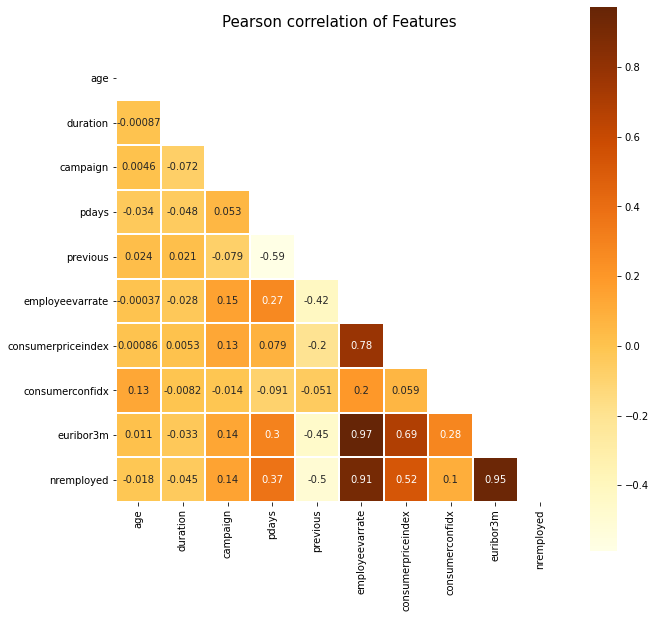

In [0]:
%matplotlib inline
#data=dfbank.toPandas()
data=dfpearson.toPandas()
corr = data.corr()
f, ax = plt.subplots(figsize=(10,10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

_ = sns.heatmap(corr, cmap="YlOrBr", square=True, ax=ax,mask=mask, annot=True, linewidth=0.1)

plt.title("Pearson correlation of Features", y=1.05, size=15)

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=dfpearson.columns, outputCol=vector_col)
df_vector = assembler.transform(dfpearson).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector , vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
dfpearsoncorr = spark.createDataFrame(corrmatrix,dfpearson.columns)
dfpearsoncorr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 age|            duration|            campaign|               pdays|            previous|     employeevarrate|  consumerpriceindex|     consumerconfidx|           euribor3m|          nremployed|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-8.65705010140946...|0.004593580493413...|-0.03436895116685874|0.024364740936116586|-3.70685467441389...|8.567149710780315E-4| 0.12937161424620175|0.010767429541674808|-0.01772513191192759|
|-8.65705010140946...|                 1.0|-0.07169922626415345|-0.04757701544561204|0.020640350701749105|-0.02796788448933...|0.005312267762748445|-0.0

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler,StringIndexer,StandardScaler
from pyspark.ml import Pipeline

###Data Cleaning and balancing unbalanced dataset by adding weights

In [0]:
data=dfbank.select(['job','marital','housing','default','pdaysnew','contactnew','previous','consumerpriceindex','consumerconfidx','euribor3m','nremployed','employeevarrate','duration','campaign','output','y','age_bucket'])

In [0]:
data=data.dropna()

In [0]:

import numpy as np
import pandas as pd
from itertools import chain
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

In [0]:
#One of the challenges faced during building the models for the dataset is higher accuracies due to unbalanced model, so we tried to balance datasets by adding weights for output categorical variable output/y

In [0]:
y_collect = data.select("y").groupBy("y").count().collect()
unique_y = [x["y"] for x in y_collect]
total_y = sum([x["count"] for x in y_collect])
unique_y_count = len(y_collect)
bin_count = [x["count"] for x in y_collect]
#find weights for output/y variable to balance the dataset
class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
print(class_weights_spark) 

{'no': 0.5634781656999015, 'yes': 4.438362068965517}


In [0]:
mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
 
data = data.withColumn("weight", mapping_expr.getItem(F.col("y")))
#.\
#withColumnRenamed("weight","output")

#Random Forest Classifier

In [0]:
train_data,val_data,held_out=data.randomSplit([0.65,0.15,0.2])

In [0]:
job_indexer = StringIndexer(inputCol='job',outputCol='job_index',handleInvalid='keep')
marital_indexer=StringIndexer(inputCol='marital',outputCol='marital_index',handleInvalid='keep')
housing_indexer=StringIndexer(inputCol='housing',outputCol='housing_index',handleInvalid='keep')
default_indexer=StringIndexer(inputCol='default',outputCol='default_index',handleInvalid='keep')
pdays_indexer=StringIndexer(inputCol='pdaysnew',outputCol='pdays_index',handleInvalid='keep')
contact_indexer=StringIndexer(inputCol='contactnew',outputCol='contact_index',handleInvalid='keep')

#['job','marital','housing','default','pdaysnew','contactnew','previous','consumerpriceindex','euribor3m','nremployed','employeevarrate','duration','campaign','output','y'
 

In [0]:
assembler =  VectorAssembler(inputCols=['job_index','marital_index','housing_index','default_index','previous','contact_index','pdays_index','consumerpriceindex','euribor3m','nremployed','employeevarrate','campaign'],
                          outputCol="unscaled_features")

In [0]:
scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

In [0]:
#dt_model = DecisionTreeClassifier(labelCol='priority_index',maxBins=5000)
rf = RandomForestClassifier(labelCol='output', featuresCol="features",weightCol='weight')

In [0]:
pipe = Pipeline(stages=[job_indexer,marital_indexer,housing_indexer,default_indexer,contact_indexer,pdays_indexer,assembler,scaler,rf])

In [0]:
fit_model=pipe.fit(train_data)

In [0]:

results = fit_model.transform(val_data)

In [0]:
results.select(['output','prediction']).show()

+------+----------+
|output|prediction|
+------+----------+
|     1|       1.0|
|     0|       1.0|
|     0|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



##Evaluation of model

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='output',metricName='areaUnderROC')

In [0]:
AUC = AUC_evaluator.evaluate(results)

In [0]:
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7497401264942728


In [0]:
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='output',metricName='areaUnderPR')

In [0]:
PR = PR_evaluator.evaluate(results)

In [0]:
print("The area under the PR curve is {}".format(PR))

The area under the PR curve is 0.3097298595563216


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="output", predictionCol="prediction", metricName="accuracy")

In [0]:
accuracy = ACC_evaluator.evaluate(results)

In [0]:
print("The accuracy of the model is {}".format(accuracy))

The accuracy of the model is 0.8396088019559902


In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
y_true = results.select("output")
y_true = y_true.toPandas()

y_pred = results.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix: \n {}".format(cnf_matrix))

Below is the confusion matrix: 
 [[4739  748]
 [ 236  412]]


###Held out data evaluation

In [0]:
##Testing on heldout dataset
results2 = fit_model.transform(held_out)
results2.select(['output','prediction']).show()

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='output',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(results2)
print("The area under the curve is {}".format(AUC))

PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='output',metricName='areaUnderPR')
PR = PR_evaluator.evaluate(results2)
print("The area under the PR curve is {}".format(PR))

ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="output", predictionCol="prediction", metricName="accuracy")

accuracy = ACC_evaluator.evaluate(results2)
print("The accuracy of the model is {}".format(accuracy))

y_true = results2.select("output")
y_true = y_true.toPandas()

y_pred = results2.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix: \n {}".format(cnf_matrix))

+------+----------+
|output|prediction|
+------+----------+
|     0|       1.0|
|     0|       1.0|
|     0|       1.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows

The area under the curve is 0.7319185775657339
The area under the PR curve is 0.30477454865368303
The accuracy of the model is 0.8298632499692005
Below is the confusion matrix: 
 [[6182 1020]
 [ 361  554]]


#Gradient Boosted Tree Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier

In [0]:
age_bucket=StringIndexer(inputCol='age_bucket',outputCol='age_index',handleInvalid='keep')
job_indexer = StringIndexer(inputCol='job',outputCol='job_index',handleInvalid='keep')
marital_indexer=StringIndexer(inputCol='marital',outputCol='marital_index',handleInvalid='keep')
housing_indexer=StringIndexer(inputCol='housing',outputCol='housing_index',handleInvalid='keep')
default_indexer=StringIndexer(inputCol='default',outputCol='default_index',handleInvalid='keep')
pdays_indexer=StringIndexer(inputCol='pdaysnew',outputCol='pdays_index',handleInvalid='keep')
contact_indexer=StringIndexer(inputCol='contactnew',outputCol='contact_index',handleInvalid='keep')

In [0]:
assembler =  VectorAssembler(inputCols=['age_index','job_index','marital_index','housing_index','default_index','previous','contact_index','pdays_index','consumerpriceindex','euribor3m','nremployed','employeevarrate','campaign'],
                          outputCol="unscaled_features")

In [0]:
labelIndexer = StringIndexer(inputCol="y", outputCol="yindex").fit(data)

In [0]:
(trainingData, valData, holdData) = data.randomSplit([0.65, 0.15,0.2])

In [0]:
scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

In [0]:
gbt = GBTClassifier(labelCol="yindex", featuresCol="unscaled_features",weightCol='weight',maxIter=10)

In [0]:
pipeline = Pipeline(stages=[labelIndexer, job_indexer,marital_indexer,housing_indexer,default_indexer,age_bucket,pdays_indexer,contact_indexer,assembler,scaler, gbt])

In [0]:
model = pipeline.fit(trainingData)

In [0]:
predictions = model.transform(valData)

In [0]:
predictions.select("prediction", "yindex", "features").show(100)

+----------+------+--------------------+
|prediction|yindex|            features|
+----------+------+--------------------+
|       1.0|   0.0|(13,[2,3,8,9,10,1...|
|       1.0|   1.0|(13,[2,3,8,9,10,1...|
|       1.0|   1.0|(13,[2,3,8,9,10,1...|
|       1.0|   0.0|[1.92253134341004...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|[1.92253134341004...|
|       0.0|   0.0|[1.92253134341004...|
|       0.0|   0.0|[1.92253134341004...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|[1.92253134341004...|
|       0.0|   0.0|[1.92253134341004...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   0.0|[1.92253134341004...|
|       0.0|   0.0|(13,[2,3,8,9,10,1...|
|       0.0|   1.0|(13,[2,3,8,9,10,1...|
|       0.0|   0

##Evaluation of model

In [0]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="yindex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy =",accuracy)##highest accuracy than other models
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.8128559804719284
Test Error = 0.187144


In [0]:
y_true = predictions.select("yindex")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix: \n {}".format(cnf_matrix))

Below is the confusion matrix: 
 [[4587  875]
 [ 275  408]]


###Held out data evaluation

In [0]:
predictions = model.transform(held_out)
predictions.select(['yindex','prediction']).show()

evaluator = MulticlassClassificationEvaluator(
    labelCol="yindex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy =",accuracy)##highest accuracy than other models
print("Test Error = %g" % (1.0 - accuracy))

y_true = predictions.select("output")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix: \n {}".format(cnf_matrix))

+------+----------+
|yindex|prediction|
+------+----------+
|   0.0|       1.0|
|   0.0|       1.0|
|   0.0|       1.0|
|   0.0|       0.0|
|   1.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
|   0.0|       0.0|
+------+----------+
only showing top 20 rows

Accuracy = 0.824565726253542
Test Error = 0.175434
Below is the confusion matrix: 
 [[6111 1091]
 [ 333  582]]


#Logistic Regression

In [0]:
train_data,test_data=data.randomSplit([0.7,0.3])

In [0]:
assembler = VectorAssembler(inputCols=['job_index','marital_index','housing_index','default_index','previous','pdays_index','consumerpriceindex','euribor3m','nremployed','employeevarrate','campaign'], outputCol="unscaled_features")


In [0]:
scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="output", weightCol="weight")

In [0]:
pipe = Pipeline(stages=[job_indexer,marital_indexer,housing_indexer,default_indexer,pdays_indexer,assembler,scaler,lr])

In [0]:
lrModel = pipe.fit(train_data)

In [0]:
prediction1=lrModel.transform(test_data)

In [0]:
prediction1.select("prediction", "output").show(10)

+----------+------+
|prediction|output|
+----------+------+
|       1.0|     1|
|       1.0|     0|
|       1.0|     0|
|       1.0|     1|
|       1.0|     0|
|       1.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
|       0.0|     0|
+----------+------+
only showing top 10 rows



###Evaluation of model

In [0]:
AUC_evaluator1 = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='output',metricName='areaUnderROC')

In [0]:
AUC = AUC_evaluator1.evaluate(prediction1)

In [0]:
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7127728579051827


In [0]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="output", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction1)
print("Accuracy =",accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.7108039584526049
Test Error = 0.289196


#SVC Model

In [0]:
from pyspark.ml.classification import LinearSVC,DecisionTreeClassifier
assembler =  VectorAssembler(inputCols=['employeevarrate','consumerpriceindex','consumerconfidx','euribor3m','nremployed'],outputCol="unscaled_features")
 
scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")
svc_model = LinearSVC(labelCol='output',weightCol='weight')
pipe = Pipeline(stages=[assembler,scaler,svc_model])

In [0]:
fit_model2=pipe.fit(train_data)
results2 = fit_model2.transform(test_data)

In [0]:
results2.select(['output','prediction']).show()

+------+----------+
|output|prediction|
+------+----------+
|     1|       1.0|
|     0|       1.0|
|     0|       1.0|
|     1|       1.0|
|     0|       1.0|
|     0|       1.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [0]:
AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='output',metricName='areaUnderROC')

###Evaluation of model

In [0]:
AUC = AUC_evaluator.evaluate(results2)
print("The area under the curve is {}".format(AUC))

The area under the curve is 0.7166768443347216


In [0]:
PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='output',metricName='areaUnderPR')
PR = PR_evaluator.evaluate(results2)
print("The area under the PR curve is {}".format(PR))
evaluator = MulticlassClassificationEvaluator(
    labelCol="output", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(results2)
print("Accuracy =",accuracy)
print("Test Error = %g" % (1.0 - accuracy))
y_true = results2.select("output")
y_true = y_true.toPandas()
 
y_pred = results2.select("prediction")
y_pred = y_pred.toPandas()
 
cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix: \n {}".format(cnf_matrix))

The area under the PR curve is 0.22670089928133505
Accuracy = 0.7199640140672283
Test Error = 0.280036
Below is the confusion matrix: 
 [[7817 3026]
 [ 398  986]]


#Conclusion

In [0]:
###Features like 'job_index','marital_index','housing_index','default_index','previous','contact_index','pdays_index','consumerpriceindex','euribor3m','nremployed','employeevarrate','campaign' helped us to build model with better accuracy for predicting customers subscribing for term deposit